# Drug Review Analysis

In [228]:
#!pip install imblearn

     |████████████████████████████████| 189 kB 2.6 MB/s eta 0:00:01


In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

sns.set_theme()

## Initial data import and analysis

In [3]:
train_data = pd.read_csv('drugLib_raw/drugLibTrain_raw.tsv', sep='\t', header=0, names=['id', 'drug', 'rating', 'effectiveness', 'side_effects', 'condition', 'benefits_review', 'side_effects_review', 'comments_review'])
train_data.head()

,id,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


### Droping 'id' column because it doesn't add any relevant information

In [5]:
train_data.drop(columns='id', inplace=True)
train_data.head()

,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


### Checking data types and presence of NaNs

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   3107 non-null   int64 
 1   drug                 3107 non-null   object
 2   rating               3107 non-null   int64 
 3   effectiveness        3107 non-null   object
 4   side_effects         3107 non-null   object
 5   condition            3106 non-null   object
 6   benefits_review      3107 non-null   object
 7   side_effects_review  3105 non-null   object
 8   comments_review      3099 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [6]:
# Checking which columns have NaNs
train_data.isna().any()

drug                   False
rating                 False
effectiveness          False
side_effects           False
condition               True
benefits_review        False
side_effects_review     True
comments_review         True
dtype: bool

In [108]:
# Checking how many rows are affected by NaNs
train_data[train_data.isna().any(axis=1)].shape[0]

9

In [86]:
# Visualizing the rows that have NaNs
train_data[train_data.isna().any(axis=1)]

,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
147,doxycycline,4,Moderately Effective,Severe Side Effects,epididymitus,Treatment cleared up the infection.,Treatment ended 2 months ago and have still go...,NaN
400,hyzaar,8,Highly Effective,Moderate Side Effects,hypertension,Pills helped to lower my blood pressure. Also...,"Back pain, especially after a missed dose. In...",NaN
407,ritalin-la,8,Considerably Effective,Mild Side Effects,adhd,This medication enabled me to think clearly. ...,"This medication caused me to be nervous, tremb...",NaN
1238,seasonique,9,Highly Effective,Mild Side Effects,prevent menstral migranes,Experienced 1 migrane in the past year since o...,Noticed light skin iritation. Take the light ...,NaN
1468,seasonique,4,Considerably Effective,Moderate Side Effects,preventing pregnancy,preventing pregnancy,This pill was great b/c i didn't have any peri...,NaN
1965,xenical,3,Marginally Effective,No Side Effects,over weight,i have been on xenical for a little over 2 wee...,i dont have any other then now i am constipated,NaN
2402,levothroid,10,Highly Effective,No Side Effects,thyroid,balancing of thyroid back to normal range. Pri...,NaN,.1mg daily orally.
2488,keflex,2,Ineffective,No Side Effects,NaN,None. I had a bacterial infection accompanyin...,The only good point I suppose is that there wa...,Absoutely innefective. I easily could have be...
2705,flonase,8,Considerably Effective,No Side Effects,plugged up nose related to seasonal allergies,cleared up nose,none,NaN
2891,doxycycline,6,Moderately Effective,No Side Effects,acne,Controlled acne breakouts to some extent when ...,NaN,Took Doxylin 50 mg once daily for 3 months. I...


### Handling NaNs

In [88]:
# The NaNs present on the side_effects_reviews column correspond to drugs that had no side effects.
# Since we have a small dataset, it was decided to fill those NaNs with a string saying 'no side effects'.
train_data.fillna({'side_effects_review': 'no side effects'}, inplace=True)

# Checking if it worked
#train_data[train_data.isna().any(axis=1)].shape

(9, 8)

In [93]:
train_data[train_data.isna().any(axis=1)]

,drug,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,comments_review
147,doxycycline,4,Moderately Effective,Severe Side Effects,epididymitus,Treatment cleared up the infection.,Treatment ended 2 months ago and have still go...,NaN
400,hyzaar,8,Highly Effective,Moderate Side Effects,hypertension,Pills helped to lower my blood pressure. Also...,"Back pain, especially after a missed dose. In...",NaN
407,ritalin-la,8,Considerably Effective,Mild Side Effects,adhd,This medication enabled me to think clearly. ...,"This medication caused me to be nervous, tremb...",NaN
1238,seasonique,9,Highly Effective,Mild Side Effects,prevent menstral migranes,Experienced 1 migrane in the past year since o...,Noticed light skin iritation. Take the light ...,NaN
1468,seasonique,4,Considerably Effective,Moderate Side Effects,preventing pregnancy,preventing pregnancy,This pill was great b/c i didn't have any peri...,NaN
1965,xenical,3,Marginally Effective,No Side Effects,over weight,i have been on xenical for a little over 2 wee...,i dont have any other then now i am constipated,NaN
2488,keflex,2,Ineffective,No Side Effects,NaN,None. I had a bacterial infection accompanyin...,The only good point I suppose is that there wa...,Absoutely innefective. I easily could have be...
2705,flonase,8,Considerably Effective,No Side Effects,plugged up nose related to seasonal allergies,cleared up nose,none,NaN
2921,ceclor,1,Ineffective,Severe Side Effects,ear infection,My son had an allergic reaction. He broke out...,Time - let them go away on their own,NaN


In [122]:
# Trying to infer the condition that was being treated.
# This column might be usefull for a more complex model, that also uses the rating and condition columns, 
# to predict the effectiveness and side_effects rating.
print('Benefits : ', train_data.loc[2488]['benefits_review'])
print('\nSide effects : ', train_data.loc[2488]['side_effects_review'],'\n')
print(train_data[train_data['drug'] == 'keflex']['condition'])

# Having determined that the condition was a bacterial infection, lets fill the NaN with it.
train_data.fillna({'condition': 'bacterial infection'}, inplace=True)


Benefits :  None.  I had a bacterial infection accompanying my flu and there wasnt a single noticeable benefit.

Side effects :  The only good point I suppose is that there was no adverse reaction, such as yeast infection or stomach upset. The downside was the bacterial infection quickly got worse. 

208                                pre-surgery
594      shortness of breath, itching all over
883     severe upper respitory tract infection
1109                           tooth infection
1979                           polinoidal cyst
2196                        bladder infections
2329                      skin wound/infection
2488                       bacterial infection
2528                   post surgery antibiotic
2598                 post operative antibiotic
Name: condition, dtype: object


## Doing some exploration

In [129]:
# Number of unique drugs
train_data.drug.unique().shape[0]

502

In [130]:
# Number of unique conditions
train_data.condition.unique().shape[0]

1426

In [202]:
# Listing drugs, the conditions they treat and how many entries there are for each pair (drug, condition)
f = train_data.groupby(by=['drug', 'condition']).count()
f

rating  \
drug     condition                                                   
abilify  bipolar                                                 1   
         bipolar disorder                                        1   
         depression                                              1   
         depression not resolved with antidepressant drugs       1   
         depression/anxiety                                      1   
...                                                            ...   
zyrtec   year round allergies                                    2   
zyrtec-d allergies                                               1   
         hay fever                                               1   
         pollen, dust, mold and tree allergies                   1   
zyvox    mrsa                                                    1   

                                                            effectiveness  \
drug     condition                                                          
abilify  bipolar                                                        1   
         bipolar disorder                                               1   
         depression                                                     1   
         depression not resolved with antidepressant drugs              1   
         depression/anxiety                                             1   
...                                                                   ...   
zyrtec   year round allergies                                           2   
zyrtec-d allergies                                                      1   
         hay fever                                                      1   
         pollen, dust, mold and tree allergies                          1   
zyvox    mrsa                                                           1   

                                                            side_effects  \
drug     condition                                                         
abilify  bipolar                                                       1   
         bipolar disorder                                              1   
         depression                                                    1   
         depression not resolved with antidepressant drugs             1   
         depression/anxiety                                            1   
...                                                                  ...   
zyrtec   year round allergies                                          2   
zyrtec-d allergies                                                     1   
         hay fever                                                     1   
         pollen, dust, mold and tree allergies                         1   
zyvox    mrsa                                                          1   

                                                            benefits_review  \
drug     condition                                                            
abilify  bipolar                                                          1   
         bipolar disorder                                                 1   
         depression                                                       1   
         depression not resolved with antidepressant drugs                1   
         depression/anxiety                                               1   
...                                                                     ...   
zyrtec   year round allergies                                             2   
zyrtec-d allergies                                                        1   
         hay fever                                                        1   
         pollen, dust, mold and tree allergies                            1   
zyvox    mrsa                                                             1   

                                                            side_effects_review  \
drug     condition                             

In [128]:
# Seeing how many times each drug was used and what % of the reviews it represents
drugs = train_data.groupby(by=['drug']).count()
drugs.drop(columns=['effectiveness', 'side_effects', 'condition', 'benefits_review', 'side_effects_review', 'comments_review'], inplace=True)
drugs.reset_index(inplace=True)
drugs.rename(columns={'rating': 'count'}, inplace=True)
drugs.sort_values(by='count', ascending=False, inplace=True)
drugs.reset_index(drop=True, inplace=True)
drugs['%reviews'] = round((drugs['count'] / drugs['count'].sum()) * 100, 3)
drugs

,drug,count,%reviews
0,lexapro,63,2.028
1,prozac,46,1.481
2,retin-a,45,1.448
3,zoloft,45,1.448
4,paxil,38,1.223
...,...,...,...
497,pamelor,1,0.032
498,penicillin-v,1,0.032
499,penlac,1,0.032
500,pepcid,1,0.032


## Creating the datasets to be used to predict the ratings and text type

In [150]:
# Creating the rating prediction datasets
train_data_benefits = train_data[['rating', 'condition', 'benefits_review', 'effectiveness']].copy()
train_data_side_effects = train_data[['rating', 'condition', 'side_effects_review' ,'side_effects']].copy()

In [126]:
train_data_benefits.head()

,rating,condition,benefits_review,effectiveness
0,4,management of congestive heart failure,slowed the progression of left ventricular dys...,Highly Effective
1,1,birth prevention,Although this type of birth control has more c...,Highly Effective
2,10,menstrual cramps,I was used to having cramps so badly that they...,Highly Effective
3,3,acid reflux,The acid reflux went away for a few months aft...,Marginally Effective
4,2,fibromyalgia,I think that the Lyrica was starting to help w...,Marginally Effective


In [127]:
train_data_side_effects.head()

,rating,condition,side_effects_review,side_effects
0,4,management of congestive heart failure,"cough, hypotension , proteinuria, impotence , ...",Mild Side Effects
1,1,birth prevention,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...",Severe Side Effects
2,10,menstrual cramps,Heavier bleeding and clotting than normal.,No Side Effects
3,3,acid reflux,"Constipation, dry mouth and some mild dizzines...",Mild Side Effects
4,2,fibromyalgia,I felt extremely drugged and dopey. Could not...,Severe Side Effects


### Check our data for a skew

There is a known phenomenon where ratings tend to be skewed towards higher values, so we can expect the benefits rating to be affected this phenomenon.
Also, the drugs are already being commercialized so they are not supposed to provoke strong reactions on the users. So we can assume there will be also a skew on this column.

Therefore, we should check our data for the skewedness.

In [203]:
train_data_benefits['effectiveness'].value_counts()

Highly Effective          1330
Considerably Effective     928
Moderately Effective       415
Ineffective                247
Marginally Effective       187
Name: effectiveness, dtype: int64

<AxesSubplot:xlabel='count', ylabel='effectiveness'>

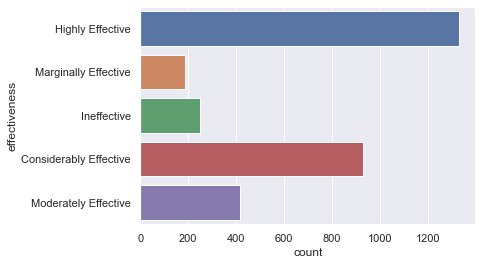

In [207]:
sns.countplot(y='effectiveness', data=train_data_benefits)

In [205]:
train_data_side_effects['side_effects'].value_counts()

Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: side_effects, dtype: int64

<AxesSubplot:xlabel='count', ylabel='side_effects'>

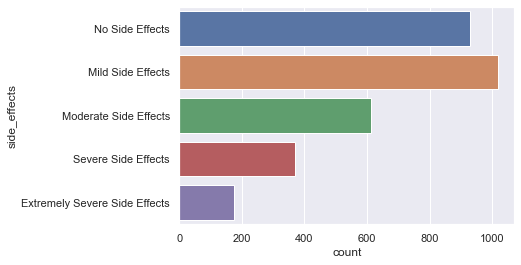

In [210]:
sns.countplot(y='side_effects', data=train_data_side_effects,
              order=['No Side Effects', 'Mild Side Effects', 'Moderate Side Effects', 'Severe Side Effects', 'Extremely Severe Side Effects'])


As expected, there is a significant skew in the data. There are two possible solutions for this effect. One is under-sampling the data and the other is oversampling it. We will try both methods as wel as using unsampled data.

In [225]:
# Undersampling benefits
a = train_data_benefits[train_data_benefits['effectiveness'] == 'Ineffective'].sample(n=187)
b = train_data_benefits[train_data_benefits['effectiveness'] == 'Highly Effective'].sample(n=187)
c = train_data_benefits[train_data_benefits['effectiveness'] == 'Considerably Effective'].sample(n=187)
d = train_data_benefits[train_data_benefits['effectiveness'] == 'Moderately Effective'].sample(n=187)
e = train_data_benefits[train_data_benefits['effectiveness'] == 'Marginally Effective'].sample(n=187)

under_sample_benefits = pd.concat([a,b,c,d,e], ignore_index=True).copy()
#under_sample_benefits


In [226]:
# Undersampling side effects
g = train_data_side_effects[train_data_side_effects['side_effects'] == 'Mild Side Effects'].sample(n=175)
h = train_data_side_effects[train_data_side_effects['side_effects'] == 'Severe Side Effects'].sample(n=175)
i = train_data_side_effects[train_data_side_effects['side_effects'] == 'No Side Effects'].sample(n=175)
j = train_data_side_effects[train_data_side_effects['side_effects'] == 'Extremely Severe Side Effects']
k = train_data_side_effects[train_data_side_effects['side_effects'] == 'Moderate Side Effects'].sample(n=175)

under_sample_side_effects = pd.concat([g,h,i,j,k], ignore_index=True).copy()
#under_sample_side_effects

In [229]:
def oversample(X,y):
    sm = SMOTE(sample_strategy='all')
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

https://aclanthology.org/W10-1205/

In [237]:
X = train_data_benefits['benefits_review']
y = train_data_benefits['effectiveness']
le = LabelEncoder()
y = le.fit_transform(y)

In [239]:
x1,y1 = oversample(X, y)

TypeError: __init__() got an unexpected keyword argument 'sample_strategy'

In [236]:
x1

array(['Highly Effective', 'Highly Effective', 'Highly Effective', ...,
       'Marginally Effective', 'Considerably Effective',
       'Moderately Effective'], dtype=object)

In [ ]:
y1